In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time as t
from time import perf_counter as cput
import scipy.constants as spc
import matplotlib.ticker as ticker
import awkward as ak

In [2]:
path_prefix = 'D:/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
ext_path = "H:/EPE_file_storage/"
ext_modelpath = ext_path + "Model/"
# ext_datapath = ext_path + "data_storage/STMC/"
datapath = 'D:/Work/Datastorage/'
ext_plotpath = ext_path + "plots/"
pipm_path = datapath + "pipm/"
stmc_path = datapath + "STMC/"


In [3]:
import sys
sys.path.append(path_prefix)
import os
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot as ur
import keras.utils.io_utils as kiu
import h5py as h5
import tensorflow as tf
from util import deep_set_util as dsu
from util.deep_set_util import track_branches, event_branches, ak_event_branches, np_event_branches, geo_branches
from copy import deepcopy

In [4]:
# setup root files
Nfile = 10
fileNames = []
file_prefix = pipm_path + 'user.angerami.24559744.OutputStream._000'
for i in range(1,Nfile+1):
    endstring = f'{i:03}'
    fileNames.append(file_prefix + endstring + '.root')

In [8]:
file = ur.open(fileNames[0])

In [13]:
import matplotlib.pyplot as plt

In [20]:
a = file['EventTree']['truthPartE'].array()

In [21]:
a[1]

<Array [719] type='1 * float32'>

(array([11427.,  1468.,   938.,   628.,   470.,   408.,   355.,   322.,
          284.,   192.,   206.,   205.,   172.,   156.,   147.,   132.,
          132.,   117.,   141.,    87.,   107.,   100.,   100.,   104.,
           68.,    92.,    74.,    82.,    92.,    72.,    74.,    59.,
           75.,    65.,    58.,    62.,    62.,    58.,    65.,    62.,
           40.,    55.,    53.,    58.,    57.,    37.,    40.,    55.,
           41.,    46.]),
 array([2.0010337e-01, 4.0187996e+01, 8.0175888e+01, 1.2016378e+02,
        1.6015167e+02, 2.0013957e+02, 2.4012746e+02, 2.8011536e+02,
        3.2010324e+02, 3.6009113e+02, 4.0007904e+02, 4.4006693e+02,
        4.8005481e+02, 5.2004272e+02, 5.6003058e+02, 6.0001849e+02,
        6.4000641e+02, 6.7999426e+02, 7.1998218e+02, 7.5997003e+02,
        7.9995795e+02, 8.3994586e+02, 8.7993372e+02, 9.1992163e+02,
        9.5990955e+02, 9.9989740e+02, 1.0398853e+03, 1.0798732e+03,
        1.1198611e+03, 1.1598490e+03, 1.1998369e+03, 1.2398248e+03

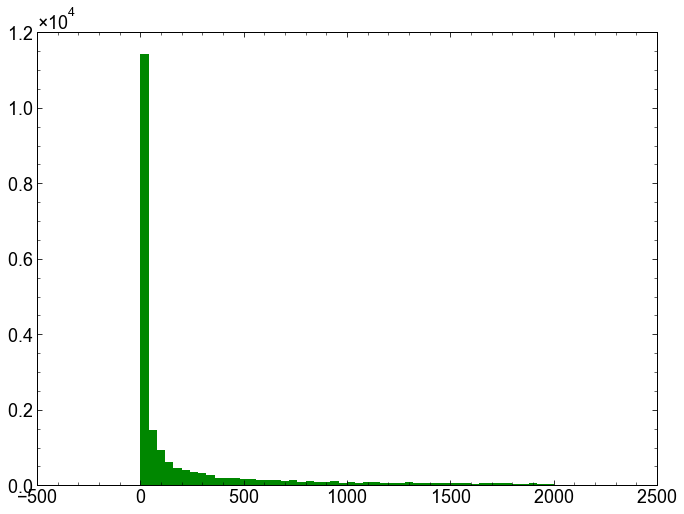

In [18]:

plt.hist(file['EventTree']['truthPartE'].array(), bins=50)


In [5]:
# setup geo map and geo dict
geo_file = ur.open(fileNames[0])
geo_tree = geo_file['CellGeo']
geo_dict = dsu.dict_from_tree(tree=geo_tree, branches=None, np_branches=geo_branches)

# cell geometry data
cell_geo_ID = geo_dict['cell_geo_ID']
cell_ID_dict = dict(zip(cell_geo_ID, np.arange(len(cell_geo_ID))))

# additional geometry data
layer_rPerp = np.array([1540., 1733., 1930., 2450., 3010., 3630.])
track_sample_layer = np.array([1,2,3,12,13,14])

In [9]:
# keep track of data
k = 1 # used to keep track of file number
tot_nEvts = 0 # used for keeping track of total number of events
max_nPoints = 0 # Keep track of the largest point cloud overall
t_tot = 0 # total time
num_zero_tracks = 0

In [7]:
def DeltaR(coords, ref):
    ''' Straight forward function, expects Nx2 inputs for coords, 1x2 input for ref '''
    ref = np.tile(ref, (len(coords[:,0]), 1))
    DeltaCoords = np.subtract(coords, ref)
    ## Mirroring ##
    gt_pi_mask = DeltaCoords > np.pi
    lt_pi_mask = DeltaCoords < - np.pi
    DeltaCoords[lt_pi_mask] = DeltaCoords[lt_pi_mask] + 2*np.pi
    DeltaCoords[gt_pi_mask] = DeltaCoords[gt_pi_mask] - 2*np.pi
    return np.sqrt(DeltaCoords[:,0]**2 + DeltaCoords[:,1]**2)

def find_max_dim_tuple(events, event_dict):
    nEvents = len(events)
    max_clust = 0
    
    for i in range(nEvents):
        event = events[i,0]
        track_nums = events[i,1]
        clust_nums = events[i,2]
        
        clust_num_total = 0
        # set this to six for now to handle single track events, change later
        track_num_total = 10 # I think its seven but keep a buffer
        
        # Check if there are clusters, None type object may be associated with it
        if clust_nums is not None:
            # Search through cluster indices
            for clst_idx in clust_nums:
                nInClust = len(event_dict['cluster_cell_ID'][event][clst_idx])
                # add the number in each cluster to the total
                clust_num_total += nInClust

        total_size = clust_num_total + track_num_total
        if total_size > max_clust:
            max_clust = total_size
    
    # 6 for energy, eta, phi, rperp, track flag, sample layer
    return (nEvents, max_clust, 6)

def dict_from_tree(tree, branches=None, np_branches=None):
    ''' Loads branches as default awkward arrays and np_branches as numpy arrays. '''
    dictionary = dict()
    if branches is not None:
        for key in branches:
            branch = tree.arrays()[key]
            dictionary[key] = branch
            
    if np_branches is not None:
        for np_key in np_branches:
            np_branch = np.ndarray.flatten(tree.arrays()[np_key].to_numpy())
            dictionary[np_key] = np_branch
    
    if branches is None and np_branches is None:
        raise ValueError("No branches passed to function.")
        
    return dictionary

def find_index_1D(values, dictionary):
    ''' Use a for loop and a dictionary. values are the IDs to search for. dict must be in format 
    (cell IDs: index) '''
    idx_vec = np.zeros(len(values), dtype=np.int32)
    for i in range(len(values)):
        idx_vec[i] = dictionary[values[i]]
    return 

In [8]:
# setup memory map
X_large = np.lib.format.open_memmap(pipm_path+'X_large.npy', mode='w+', dtype=np.float64,
                       shape=(1000000,1700,6), fortran_order=False, version=None)
Y_large = np.lib.format.open_memmap(pipm_path+'Y_large.npy', mode='w+', dtype=np.float64,
                       shape=(1000000,3), fortran_order=False, version=None)
Eta_large = np.empty(1000000)

In [12]:
trk_proj_eta = ['trackEta_EMB1', 'trackEta_EMB2', 'trackEta_EMB3',
    'trackEta_EME1', 'trackEta_EME2', 'trackEta_EME3', 'trackEta_HEC0',
    'trackEta_HEC1', 'trackEta_HEC2', 'trackEta_HEC3', 'trackEta_TileBar0',
    'trackEta_TileBar1', 'trackEta_TileBar2', 'trackEta_TileGap1',
    'trackEta_TileGap2', 'trackEta_TileGap3', 'trackEta_TileExt0',
    'trackEta_TileExt1', 'trackEta_TileExt2']
trk_proj_phi = ['trackPhi_EMB1', 'trackPhi_EMB2', 'trackPhi_EMB3',
    'trackPhi_EME1', 'trackPhi_EME2', 'trackPhi_EME3', 'trackPhi_HEC0',
    'trackPhi_HEC1', 'trackPhi_HEC2', 'trackPhi_HEC3', 'trackPhi_TileBar0',
    'trackPhi_TileBar1', 'trackPhi_TileBar2', 'trackPhi_TileGap1',
    'trackPhi_TileGap2', 'trackPhi_TileGap3', 'trackPhi_TileExt0',
    'trackPhi_TileExt1', 'trackPhi_TileExt2']
calo_numbers = [1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
eta_trk_dict = dict(zip(trk_proj_eta, calo_numbers))

calo_layers = ['EMB1', 'EMB2', 'EMB3', 'EME1', 'EME2', 'EME3', 'HEC0', 'HEC1',
    'HEC2', 'HEC3', 'TileBar0', 'TileBar1', 'TileBar2', 'TileGap1', 'TileGap2',
    'TileGap3', 'TileExt0', 'TileExt1', 'TileExt2']
calo_numbers2 = [1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
calo_dict = dict(zip(calo_numbers2, calo_layers))

fixed_z_numbers = [5,6,7,8,9,10,11]
fixed_z_vals = [3790.03, 3983.68, 4195.84, 4461.25, 4869.50, 5424.50, 5905.00]
z_calo_dict = dict(zip(fixed_z_numbers, fixed_z_vals))

fixed_r_numbers = [1,2,3,12,13,14,15,16,17,18,19,20]
fixed_r_vals = [1532.18, 1723.89, 1923.02, 2450.00, 2995.00, 3630.00, 3215.00,
                3630.00, 2246.50, 2450.00, 2870.00, 3480.00]
r_calo_dict = dict(zip(fixed_r_numbers, fixed_r_vals))

In [16]:
for currFile in fileNames:
    
    # Check for file, a few are missing
    if not os.path.isfile(currFile):
        print()
        print('File '+currFile+' not found..')
        print()
        k += 1
        continue
    
    else:
        print()
        print('Working on File: '+str(currFile)+' - '+str(k)+'/'+str(Nfile))
        k += 1

    t0 = t.time()
    ## EVENT DICTIONARY ##
    event = ur.open(currFile)
    event_tree = event["EventTree"]
    event_dict = dict_from_tree(tree=event_tree, branches=event_branches, np_branches=np_event_branches)
    
    ## TRACK DICTIONARY ##
    track_dict = dict_from_tree(tree=event_tree,
                branches=deepcopy(trk_proj_eta+trk_proj_phi))
    
    #===================
    # APPLY CUTS =======
    #===================
    # create ordered list of events to use for index slicing
    nEvents = len(event_dict['eventNumber'])
    all_events = np.arange(0,nEvents,1,dtype=np.int32)

    # SINGLE TRACK CUT
    single_track_mask = event_dict['nTrack'] == np.full(nEvents, 1)
    single_track_filter = all_events[single_track_mask]
    
    # CENTRAL TRACKS
    # Warning: we are safe for now with single tracks but not for multiples using this
    # trackEta = ak.flatten(event_dict['trackEta'][single_track_filter]\
    #                      ).to_numpy()
    # track_eta_cut = np.abs(trackEta) < 2.5
    # track_filter = single_track_filter[track_eta_cut]
    
    # TRACKS WITH CLUSTERS
    nCluster = event_dict['nCluster'][single_track_filter]
    nz_clust_mask = nCluster != 0
    filtered_event = single_track_filter[nz_clust_mask]
    t1 = t.time()
    events_cuts_time = t1 - t0
    
    #============================================#
    ## CREATE INDEX ARRAY FOR TRACKS + CLUSTERS ##
    #============================================#
    event_indices = []
    t0 = t.time()

    for evt in filtered_event:

        # pull cluster number, don't need zero as it's loaded as a np array
        nClust = event_dict["nCluster"][evt]
        cluster_idx = np.arange(nClust)

        # Notes: this will need to handle more complex scenarios in the future for tracks with
        # no clusters

        ## DELTA R ##
        # pull coordinates of tracks and clusters from event
        # we can get away with the zeroth index because we are working with single track events
        trackCoords = np.array([event_dict["trackEta"][evt][0],
                                event_dict["trackPhi"][evt][0]])
        clusterCoords = np.stack((event_dict["cluster_Eta"][evt].to_numpy(),
                                event_dict["cluster_Phi"][evt].to_numpy()), axis=1)

        _DeltaR = DeltaR(clusterCoords, trackCoords)
        DeltaR_mask = _DeltaR < .2
        matched_clusters = cluster_idx[DeltaR_mask]

        ## CREATE LIST ##
        # Note: currently do not have track only events. Do this in the future    
        if np.count_nonzero(DeltaR_mask) > 0:
            event_indices.append((evt, 0, matched_clusters))
    
    event_indices = np.array(event_indices, dtype=np.object_)
    t1 = t.time()
    indices_time = t1 - t0
    
    #=========================#
    ## DIMENSIONS OF X ARRAY ##
    #=========================#
    t0 = t.time()
    max_dims = find_max_dim_tuple(event_indices, event_dict)
    evt_tot = max_dims[0]
    tot_nEvts += max_dims[0]
    # keep track of the largest point cloud to use for saving later
    if max_dims[1] > max_nPoints:
        max_nPoints = max_dims[1]
    
    # Create arrays
    Y_new = np.zeros((max_dims[0],3))
    X_new = np.zeros(max_dims)
    Eta_new = np.zeros(max_dims[0])
    t1 = t.time()
    find_create_max_dims_time = t1 - t0    
    
    #===================#
    ## FILL IN ENTRIES ##==============================================================
    #===================#
    t0 = t.time()
    for i in range(max_dims[0]):
        # pull all relevant indices
        evt = event_indices[i,0]
        track_idx = event_indices[i,1]
        # recall this now returns an array
        cluster_nums = event_indices[i,2]

        ##############
        ## CLUSTERS ##
        ##############
        # set up to have no clusters, further this with setting up the same thing for tracks
        target_ENG_CALIB_TOT = -1
        if cluster_nums is not None:

            # find averaged center of clusters
            cluster_Eta = event_dict['cluster_Eta'][evt].to_numpy()
            cluster_Phi = event_dict['cluster_Phi'][evt].to_numpy()
            cluster_E = event_dict['cluster_E'][evt].to_numpy()
            cl_E_tot = np.sum(cluster_E)
            
            # Energy weighted average
            av_Eta = np.dot(cluster_Eta, cluster_E)/cl_E_tot
            av_Phi = np.dot(cluster_Phi, cluster_E)/cl_E_tot

            nClust_current_total = 0
            target_ENG_CALIB_TOT = 0
            for c in cluster_nums:            
                # cluster data
                target_ENG_CALIB_TOT += event_dict['cluster_ENG_CALIB_TOT'][evt][c]
                cluster_cell_ID = event_dict['cluster_cell_ID'][evt][c].to_numpy()
                nInClust = len(cluster_cell_ID)
                cluster_cell_E = event_dict['cluster_cell_E'][evt][c].to_numpy()            
                cell_indices = find_index_1D(cluster_cell_ID, cell_ID_dict)

                cluster_cell_Eta = geo_dict['cell_geo_eta'][cell_indices]
                cluster_cell_Phi = geo_dict['cell_geo_phi'][cell_indices]
                cluster_cell_rPerp = geo_dict['cell_geo_rPerp'][cell_indices]
                cluster_cell_sampling = geo_dict['cell_geo_sampling'][cell_indices]

                # input all the data
                # note here we leave the fourth entry zeros (zero for flag!!!)
                low = nClust_current_total
                high = low + nInClust
                X_new[i,low:high,0] = cluster_cell_E
                # Normalize to average cluster centers
                X_new[i,low:high,1] = cluster_cell_Eta - av_Eta
                X_new[i,low:high,2] = cluster_cell_Phi - av_Phi
                X_new[i,low:high,3] = cluster_cell_rPerp
                X_new[i,low:high,5] = cluster_cell_sampling

                nClust_current_total += nInClust

        #####################
        ## TARGET ENERGIES ##
        #####################
        # this should be flattened or loaded as np array instead of zeroth index in future
        Y_new[i,0] = event_dict['truthPartE'][evt][0]
        Y_new[i,1] = event_dict['truthPartPt'][evt][track_idx]
        Y_new[i,2] = target_ENG_CALIB_TOT
        
        #########
        ## ETA ##
        #########
        # again only get away with this because we have a single track
        Eta_new[i] = event_dict["trackEta"][evt][track_idx]

        ############
        ## TRACKS ##
        ############
        
        trk_bool = np.zeros(len(calo_numbers), dtype=bool)
        trk_full = np.empty((len(calo_numbers), 4))
        
        for j, (eta_key, phi_key) in enumerate(zip(trk_proj_eta, trk_proj_phi)):
            
            cnum = eta_trk_dict[eta_key]
            layer = calo_dict[cnum]
            
            eta = track_dict[eta_key][evt][track_idx]
            phi = track_dict[phi_key][evt][track_idx]
            
            if np.abs(eta) < 2.5 and np.abs(phi) <= np.pi:
                trk_bool[j] = True
                trk_full[j,0] = eta
                trk_full[j,1] = phi
                trk_full[j,3] = cnum
                
                if cnum in fixed_r_numbers:
                    rPerp = r_calo_dict[cnum]
                    
                elif cnum in fixed_z_numbers:
                    z = z_calo_dict[cnum]
                    rPerp = z*2*np.exp(eta)/(np.exp(2*eta) - 1)
                    
                else:
                    raise ValueError('Calo sample num not found in dicts..')
                    
                trk_full[j,2] = rPerp
                
        # Fill in track array
        trk_proj_num = np.count_nonzero(trk_bool)
        
        if trk_proj_num == 0:
            trk_proj_num = 1
            trk_arr = np.empty((1, 6))
            num_zero_tracks += 1
            trk_arr[:,0] = event_dict['trackP'][evt][track_idx]
            trk_arr[:,1] = event_dict['trackEta'][evt][track_idx] - av_Eta
            trk_arr[:,2] = event_dict['trackPhi'][evt][track_idx] - av_Phi
            trk_arr[:,3] = 1532.18 # just place it in EMB1
            trk_arr[:,4] = 1 # track flag
            trk_arr[:,5] = 1 # place layer in EMB1
        else:
            trk_arr = np.empty((trk_proj_num, 6))
            trackP = event_dict['trackP'][evt][track_idx]
            trk_arr[:,1:4] = np.ndarray.copy(trk_full[trk_bool,:3])
            trk_arr[:,4] = np.ones(trk_proj_num)
            trk_arr[:,5] = np.ndarray.copy(trk_full[trk_bool,3])
            trk_arr[:,0] = trackP/trk_proj_num

            trk_arr[:,1] = trk_arr[:,1] - av_Eta
            trk_arr[:,2] = trk_arr[:,2] - av_Phi

        X_new[i,high:high+trk_proj_num,:] = np.ndarray.copy(trk_arr)
    
    #=========================================================================#
    t1 = t.time()
    array_construction_time = t1 - t0
    
    #=======================#
    ## ARRAY CONCATENATION ##
    #=======================#
    t0 = t.time()
    # Write to X
    old_tot = tot_nEvts - max_dims[0]
    X_large[old_tot:tot_nEvts, :max_dims[1], :6] = np.ndarray.copy(X_new)
    # pad the remainder with zeros (just to be sure)
    fill_shape = (tot_nEvts - old_tot, 1500 - max_dims[1], 6)
    X_large[old_tot:tot_nEvts, max_dims[1]:1500, :6] = np.zeros(fill_shape)
    
    # Write to Y
    Y_large[old_tot:tot_nEvts,:] = np.ndarray.copy(Y_new)
    
    # Eta
    Eta_large[old_tot:tot_nEvts] = np.ndarray.copy(Eta_new)
        
    t1 = t.time()
    time_to_memmap = t1-t0
    thisfile_t_tot = events_cuts_time+find_create_max_dims_time+indices_time\
        +array_construction_time+time_to_memmap
    t_tot += thisfile_t_tot
    
    print('Array dimension: '+str(max_dims))
    print('Number of null track projection: '+str(num_zero_tracks))
    print('Time to create dicts and select events: '+str(events_cuts_time))
    print('Time to find dimensions and make new array: '+str(find_create_max_dims_time))
    print('Time to construct index array: '+str(indices_time))
    print('Time to populate elements: '+str(array_construction_time))
    print('Time to copy to memory map: '+str(time_to_memmap))
    print('Time for this file: '+str(thisfile_t_tot))
    print('Total events: '+str(tot_nEvts))
    print('Current size: '+str((tot_nEvts,max_nPoints,6)))
    print('Total time: '+str(t_tot))
    print()



Working on File: D:/Work/Datastorage/pipm/user.angerami.24559744.OutputStream._000001.root - 3/10


ValueError: could not broadcast input array from shape (187650,) into shape (72,)

In [ ]:
np.save(file=pipm_path+'PIPM_Y_regr_'+str(Nfile)+'_files.npy', arr=Y2_large[:tot_nEvts],
        allow_pickle=False)
X = np.lib.format.open_memmap(pipm_path+'PIPM_X_'+str(Nfile)+'_files.npy',
                             mode='w+', dtype=np.float64, shape=(tot_nEvts, max_nPoints, 5))
np.copyto(dst=X, src=X_large[:tot_nEvts,:max_nPoints,:], casting='same_kind', where=True)
del X_large